# Откройте Anaconda Prompt и выполните следующию команду (команду также можно выполнить из ячейки Jupyter)
# _pip install psycopg2_
# (для MacOS) 
# _pip install psycopg2-binary_

In [1]:
# Создаем соединение c базой данных (ВНИМАНИЕ! Ваши данные для подключения с БД могут отличаться от данного примера)
import psycopg2 # драйвер для postgresql
import getpass  # прячем параль, чтобы не писать его в параметрах

conn=psycopg2.connect(user='postgres',
                      database='test',
                      host='localhost',
                      port='5432',
                      password=getpass.getpass('Insert password: ')
                        )
print(conn.get_dsn_parameters())

Insert password: ········
{'user': 'postgres', 'dbname': 'test', 'host': 'localhost', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [4]:
# Запрос кодов бимаг
import pandas as pd
query_sec="SELECT DISTINCT \"SECCODE\" FROM order_log ORDER BY \"SECCODE\" ASC"
securities=pd.read_sql_query(query_sec,conn)
securities[50:70]

,SECCODE
50,FXGD
51,FXIT
52,FXJP
53,FXMM
54,FXRB
55,FXRU
56,FXUK
57,FXUS
58,GAZA
59,GAZAP


In [5]:
# Получение данных из БД с помощью pandas
import pandas as pd
query="SELECT * FROM order_log WHERE \"TIME\"<=170000000 AND \"SECCODE\"='ALRS'"
orders=pd.read_sql_query(query,conn)
# Обратите внимание, что специальные символы Python в текстовых переменных следует отделять символом \,
# чтобы те воспринимались как обычный текст.
orders.shape

(97205, 10)

In [6]:
# Вспомогательное окно для проверки данных

# orders[orders['PRICE']==111.00]
# orders[orders['PRICE']==0]
# orders[orders['ORDERNO']==746540]

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE


In [8]:
# Построение книги лимитированных заявок (LOB)

# Устанавливаем маску лимитных заявок заявках
no_mrk_ind=orders['PRICE']!=0

#  Таблица выставленных заявок
plc=orders[['ORDERNO','BUYSELL','PRICE','VOLUME']][(orders['ACTION']==1) & no_mrk_ind]

# Таблица отозванных заявок
wdr=orders[['ORDERNO','VOLUME']][(orders['ACTION']==0) & no_mrk_ind]

# Таблица исполненных объемов
trds=orders[['ORDERNO','VOLUME']][(orders['ACTION']==2) & no_mrk_ind] 
trds=trds[['ORDERNO','VOLUME']].groupby(['ORDERNO']).sum()
trds['ORDERNO']=trds.index
trds.index=range(trds.shape[0])

# Книга (aka стакан, aka LOB)
lob=pd.merge(plc,wdr, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
lob=pd.merge(lob,trds, on='ORDERNO', how='left')
lob=lob.rename(columns={'VOLUME':'VOLUME_trds'})
lob=lob.fillna(0)
lob['TOTAL_VOL']=lob['VOLUME_plc']-lob['VOLUME_wdr']-lob['VOLUME_trds']
lob=lob[lob['TOTAL_VOL']>0]
lob=lob.pivot_table(index='PRICE',columns='BUYSELL',values='TOTAL_VOL',aggfunc='sum')
lob.sort_index(axis=0,inplace=True, ascending=False)
lob=lob.fillna(0)
lob

BUYSELL,B,S
PRICE,,
59.80,0.0,5300.0
59.00,0.0,11000.0
58.52,0.0,23500.0
58.00,0.0,3500.0
57.48,0.0,1000.0
57.00,0.0,3500.0
56.95,0.0,5900.0
56.81,0.0,14900.0
56.60,0.0,15000.0


In [6]:
# Список аргументов
    # Код эмитента - sec
    # Время - time
    # Login - db_login

def my_fun(sec,time,db_login):
    import pandas as pd
    conn=psycopg2.connect(user=db_login['user'],
                      database=db_login['database'],
                      host=db_login['host'],
                      port=db_login['port'],
                      password=getpass.getpass('Insert password: '))
    query="SELECT * FROM order_log WHERE \"TIME\"<="+str(time)+" AND \"SECCODE\"="+sec
    orders=pd.read_sql_query(query,conn)
    
    # Устанавливаем маску лимитных заявок заявках
    no_mrk_ind=orders['PRICE']!=0

    #  Таблица выставленных заявок
    plc=orders[['ORDERNO','BUYSELL','PRICE','VOLUME']][(orders['ACTION']==1) & no_mrk_ind]

    # Таблица отозванных заявок
    wdr=orders[['ORDERNO','VOLUME']][(orders['ACTION']==0) & no_mrk_ind]

    # Таблица исполненных объемов
    trds=orders[['ORDERNO','VOLUME']][(orders['ACTION']==2) & no_mrk_ind] 
    trds=trds[['ORDERNO','VOLUME']].groupby(['ORDERNO']).sum()
    trds['ORDERNO']=trds.index
    trds.index=range(trds.shape[0])

    # Книга (aka стакан, aka LOB)
    lob=pd.merge(plc,wdr, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
    lob=pd.merge(lob,trds, on='ORDERNO', how='left')
    lob=lob.rename(columns={'VOLUME':'VOLUME_trds'})
    lob=lob.fillna(0)
    lob['TOTAL_VOL']=lob['VOLUME_plc']-lob['VOLUME_wdr']-lob['VOLUME_trds']
    lob=lob[lob['TOTAL_VOL']>0]
    lob=lob.pivot_table(index='PRICE',columns='BUYSELL',values='TOTAL_VOL',aggfunc='sum')
    lob.sort_index(axis=0,inplace=True, ascending=False)
    lob=lob.fillna(0)
    
    results={'SECCODE': sec, 'TIME': time, 'LOB': lob }
    return results

In [2]:
# В продолжение разговора: если в качестве аргумента функции задать открытое соединение с БД, то так тоже будет работать. 

# Список аргументов:
    # Код эмитента - sec
    # Время -time
    # Соединение с БД - conn

def my_fun2(sec,time,conn):
    import pandas as pd
    query="SELECT * FROM order_log WHERE \"TIME\"<="+str(time)+" AND \"SECCODE\"="+sec
    orders=pd.read_sql_query(query,conn)
    
    # Устанавливаем маску лимитных заявок заявках
    no_mrk_ind=orders['PRICE']!=0

    #  Таблица выставленных заявок
    plc=orders[['ORDERNO','BUYSELL','PRICE','VOLUME']][(orders['ACTION']==1) & no_mrk_ind]

    # Таблица отозванных заявок
    wdr=orders[['ORDERNO','VOLUME']][(orders['ACTION']==0) & no_mrk_ind]

    # Таблица исполненных объемов
    trds=orders[['ORDERNO','VOLUME']][(orders['ACTION']==2) & no_mrk_ind] 
    trds=trds[['ORDERNO','VOLUME']].groupby(['ORDERNO']).sum()
    trds['ORDERNO']=trds.index
    trds.index=range(trds.shape[0])

    # Книга (aka стакан, aka LOB)
    lob=pd.merge(plc,wdr, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
    lob=pd.merge(lob,trds, on='ORDERNO', how='left')
    lob=lob.rename(columns={'VOLUME':'VOLUME_trds'})
    lob=lob.fillna(0)
    lob['TOTAL_VOL']=lob['VOLUME_plc']-lob['VOLUME_wdr']-lob['VOLUME_trds']
    lob=lob[lob['TOTAL_VOL']>0]
    lob=lob.pivot_table(index='PRICE',columns='BUYSELL',values='TOTAL_VOL',aggfunc='sum')
    lob.sort_index(axis=0,inplace=True, ascending=False)
    lob=lob.fillna(0)
    
    results={'SECCODE': sec, 'TIME': time, 'LOB': lob }
    return results

In [5]:
login={'user':'postgres', 'database':'test', 'host':'localhost', 'port':'5432'}
x=my_fun2('\'GAZP\'',120000000,conn)
x['LOB']

BUYSELL,B,S
PRICE,,
158.59,0.0,100.0
158.58,0.0,30.0
158.20,0.0,1500.0
158.00,0.0,100.0
157.55,0.0,1000.0
157.37,0.0,10.0
157.00,0.0,230.0
156.58,0.0,10.0
156.00,0.0,540.0


In [7]:
dic={'el1': [1,2,3], 'el2': 'Hello!'}
dic['el1']
x=str(100000)
time=170000000
sec='ALRS'
"SELECT * FROM order_log WHERE \"TIME\"<="+str(time)+" AND \"SECCODE\"='"+sec+"'"

'SELECT * FROM order_log WHERE "TIME"<=170000000 AND "SECCODE"=\'ALRS\''

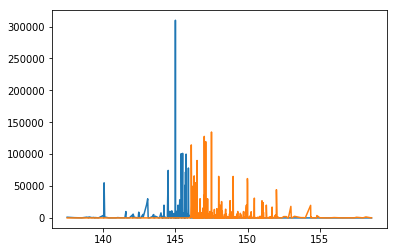

In [6]:
import matplotlib.pyplot as plt

plt.plot(x['LOB'].index,x['LOB']['B'], x['LOB'].index,x['LOB']['S'])
# plt.bar(x['LOB'].index,x['LOB']['S'])

In [8]:
# bid = x['LOB'][x['LOB']['B']>0].index[0]
# ask = x['LOB'][x['LOB']['S']>0].index[-1]
bid, ask = x['LOB'][x['LOB']['B']>0].index[0], x['LOB'][x['LOB']['S']>0].index[-1]

[bid, ask]

[145.96, 146.02]

[-100000, 100000, 140, 150]

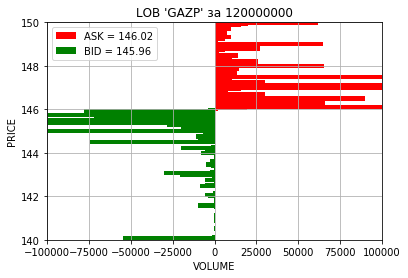

In [9]:
plt.barh(x['LOB'].index,x['LOB']['S'], height = 0.2, label = 'SELL', color = 'r')
plt.barh(x['LOB'].index,-x['LOB']['B'], height = 0.2, label='BUY', color = 'g')

plt.xlabel('VOLUME')
plt.ylabel('PRICE')
plt.title('LOB ' + str(x['SECCODE']) + ' за ' + str(x['TIME']))
plt.legend([ 'ASK = ' + str(ask), 'BID = ' + str(bid)])
plt.grid()
plt.axis([-100000,100000,140,150])


# plt.annotate(xy = [1000, ask], s = str(ask), xytext=(100,100),textcoords='offset points')


In [94]:
import pandas as pd
query="SELECT \"PRICE\" FROM order_log WHERE \"TIME\"=100000000 AND \"SECCODE\"='GAZP' AND \"ACTION\"=1"
price_in=pd.read_sql_query(query,conn)

(array([  7.,  10.,  15.,  87., 177., 266., 160.,  15.,   9.,   6.]),
 array([138.   , 140.037, 142.074, 144.111, 146.148, 148.185, 150.222,
        152.259, 154.296, 156.333, 158.37 ]),
 <a list of 10 Patch objects>)

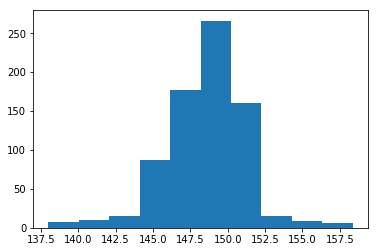

In [95]:
price_in.T
plt.hist(price_in[price_in>0].values)

# Install _jinja2_ and _weasyprint_ in Anaconda prompt

## pip install jinja2
## pip install weasyprint

In [ ]:
# Собираем автоматический отчет в виде pdf

from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os


env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("myreport.html")
template_vars = {"title":,
                "INTRO": "", 
                 "TABLE_DESC": "", 
                 "TABLE": , 
                 "IMAGE_DESC": "", 
                 "IMAGE": 
                }

html_out = template.render(template_vars, presentational_hints=True)
HTML(string=html_out).write_pdf(folder_output+report_file_name+'.pdf',stylesheets=["style.css"], presentational_hints=True)
    
